Problem 1)


Training Transformer with sequence length 10
Epoch 1/50, Train Loss: 3.1166, Val Loss: 2.9052, Val Accuracy: 0.1937
Epoch 2/50, Train Loss: 2.8253, Val Loss: 2.7758, Val Accuracy: 0.2316
Epoch 3/50, Train Loss: 2.6177, Val Loss: 2.7095, Val Accuracy: 0.2674
Epoch 4/50, Train Loss: 2.4587, Val Loss: 2.6280, Val Accuracy: 0.2821
Epoch 5/50, Train Loss: 2.2905, Val Loss: 2.6516, Val Accuracy: 0.3095
Epoch 6/50, Train Loss: 2.1781, Val Loss: 2.6237, Val Accuracy: 0.3158
Epoch 7/50, Train Loss: 2.0973, Val Loss: 2.6549, Val Accuracy: 0.3179
Epoch 8/50, Train Loss: 2.0224, Val Loss: 2.7114, Val Accuracy: 0.3158
Epoch 9/50, Train Loss: 1.9284, Val Loss: 2.6461, Val Accuracy: 0.3284
Epoch 10/50, Train Loss: 1.8558, Val Loss: 2.6822, Val Accuracy: 0.3516
Epoch 11/50, Train Loss: 1.7734, Val Loss: 2.7423, Val Accuracy: 0.3263
Epoch 12/50, Train Loss: 1.7198, Val Loss: 2.6917, Val Accuracy: 0.3495
Epoch 13/50, Train Loss: 1.6748, Val Loss: 2.7005, Val Accuracy: 0.3684
Epoch 14/50, Train Loss: 1.

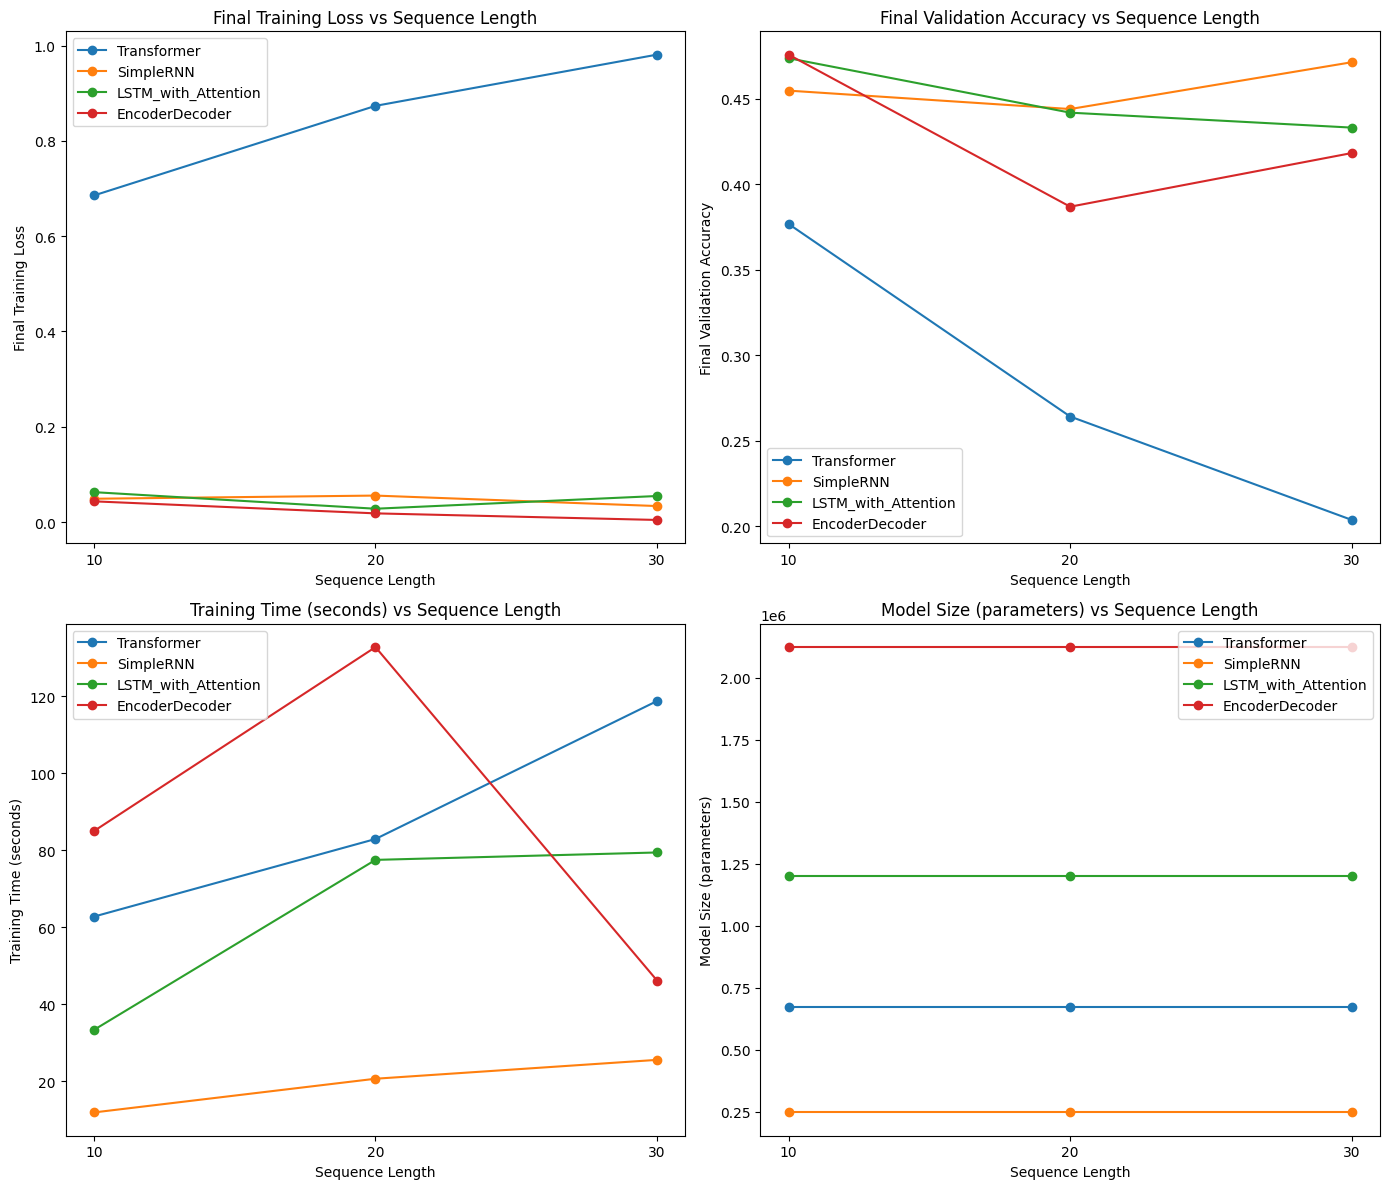

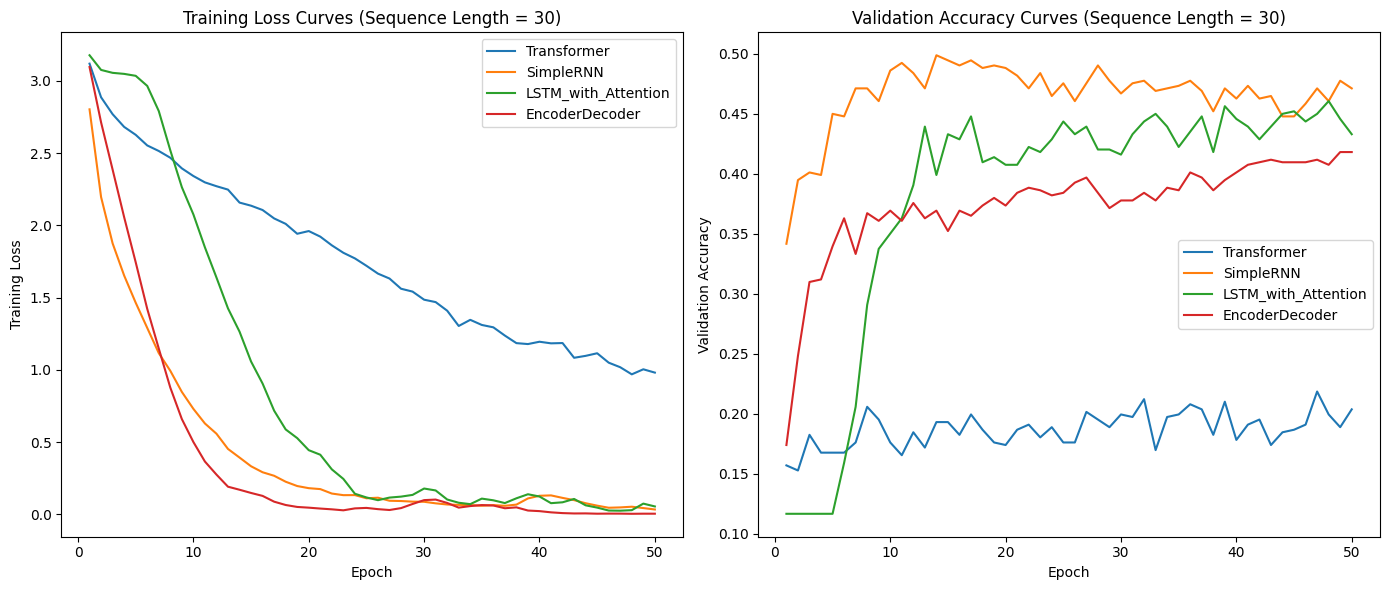


===== COMPREHENSIVE COMPARISON =====
Sequence Length | Model | Training Loss | Validation Accuracy | Training Time (s) | Parameter Count
----------------------------------------------------------------------------------------------------
            10 | Transformer     |        0.6853 |              0.3768 |            62.77 |          674093
            10 | SimpleRNN       |        0.0489 |              0.4547 |            11.90 |          247725
            10 | LSTM_with_Attention |        0.0628 |              0.4737 |            33.33 |         1202093
            10 | EncoderDecoder  |        0.0435 |              0.4758 |            84.98 |         2124205
            20 | Transformer     |        0.8735 |              0.2643 |            82.94 |          674093
            20 | SimpleRNN       |        0.0556 |              0.4440 |            20.66 |          247725
            20 | LSTM_with_Attention |        0.0280 |              0.4419 |            77.52 |         12020

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# The text sequence to train on
text = """Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it. This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text.
At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model.
One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks. RNNs are particularly well-suited for sequential data like text, as they can maintain information in 'memory' about previous characters to inform the prediction of the next character. LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks.
Training a model for next character prediction involves feeding it large amounts of text data, allowing it to learn the probability of each character's appearance following a sequence of characters. During this training process, the model adjusts its parameters to minimize the difference between its predictions and the actual outcomes, thus improving its predictive accuracy over time.
Once trained, the model can be used to predict the next character in a given piece of text by considering the sequence of characters that precede it. This can enhance user experience in text editing software, improve efficiency in coding environments with auto-completion features, and enable more natural interactions with AI-based chatbots and virtual assistants.
In summary, next character prediction plays a crucial role in enhancing the capabilities of various NLP applications, making text-based interactions more efficient, accurate, and human-like. Through the use of advanced machine learning models like RNNs and LSTMs, next character prediction continues to evolve, opening new possibilities for the future of text-based technology."""

# Create character-level dictionaries
chars = sorted(list(set(text)))
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}
vocab_size = len(chars)

# Create character-level dataset
class CharDataset(Dataset):
    def __init__(self, text, seq_length):
        self.text = text
        self.seq_length = seq_length
        self.char_to_idx = {ch: i for i, ch in enumerate(sorted(list(set(text))))}
        self.idx_to_char = {i: ch for i, ch in enumerate(sorted(list(set(text))))}
        self.total_seq = len(text) - seq_length - 1
        
    def __len__(self):
        return self.total_seq
    
    def __getitem__(self, idx):
        # Get input sequence and target character
        x = self.text[idx:idx+self.seq_length]
        y = self.text[idx+self.seq_length]
        
        # Convert to indices
        x = torch.tensor([self.char_to_idx[ch] for ch in x], dtype=torch.long)
        y = torch.tensor(self.char_to_idx[y], dtype=torch.long)
        
        return x, y

# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_seq_length=5000):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, embedding_dim)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * -(np.log(10000.0) / embedding_dim))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Updated Transformer Model with both encoder and decoder
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, nhead, hidden_dim, num_layers, dropout=0.5):
        super(TransformerModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pos_encoder = PositionalEncoding(embedding_dim)
        
        # Define encoder layers
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        # Define decoder layers
        decoder_layers = nn.TransformerDecoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layers, num_layers=num_layers)
        
        self.fc_out = nn.Linear(embedding_dim, vocab_size)
        self.embedding_dim = embedding_dim
        
    def forward(self, src):
        # src: [batch_size, seq_len]
        batch_size, seq_len = src.size()
        
        # Create masks for encoder and decoder
        src_mask = nn.Transformer.generate_square_subsequent_mask(seq_len).to(src.device)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_len).to(src.device)
        
        # Embed input sequence
        src_embedded = self.embedding(src) * np.sqrt(self.embedding_dim)  # [batch_size, seq_len, embedding_dim]
        src_embedded = self.pos_encoder(src_embedded)
        
        # For decoder input, we use the same sequence but shifted right
        # Use a start token (index 0) followed by all but the last token
        start_tokens = torch.zeros(batch_size, 1, dtype=torch.long, device=src.device)
        tgt = torch.cat([start_tokens, src[:, :-1]], dim=1)  # [batch_size, seq_len]
        
        # Embed target sequence
        tgt_embedded = self.embedding(tgt) * np.sqrt(self.embedding_dim)  # [batch_size, seq_len, embedding_dim]
        tgt_embedded = self.pos_encoder(tgt_embedded)
        
        # Run encoder
        memory = self.transformer_encoder(src_embedded, src_mask)  # [batch_size, seq_len, embedding_dim]
        
        # Run decoder with encoder's output (memory)
        output = self.transformer_decoder(
            tgt_embedded, 
            memory,
            tgt_mask=tgt_mask
        )  # [batch_size, seq_len, embedding_dim]
        
        # Project to vocabulary space
        output = self.fc_out(output)  # [batch_size, seq_len, vocab_size]
        
        return output

# Simple RNN Model for comparison
class SimpleRNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout=0.5):
        super(SimpleRNNModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, src):
        # src: [batch_size, seq_len]
        embedded = self.embedding(src)  # [batch_size, seq_len, embedding_dim]
        
        output, hidden = self.rnn(embedded)  # output: [batch_size, seq_len, hidden_dim]
        
        output = self.fc_out(output)  # [batch_size, seq_len, vocab_size]
        
        return output

# LSTM Model with cross-attention
class LSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout=0.5):
        super(LSTMWithAttention, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Cross-attention layer
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True)
        
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, src):
        # src: [batch_size, seq_len]
        embedded = self.embedding(src)  # [batch_size, seq_len, embedding_dim]
        
        lstm_output, (hidden, cell) = self.lstm(embedded)  # lstm_output: [batch_size, seq_len, hidden_dim]
        
        # Apply cross-attention over the sequence
        attn_output, _ = self.attention(
            query=lstm_output,
            key=lstm_output,
            value=lstm_output
        )
        
        output = self.fc_out(attn_output)  # [batch_size, seq_len, vocab_size]
        
        return output

# LSTM-based Encoder-Decoder Model with Cross-Attention
class EncoderDecoderModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout=0.5):
        super(EncoderDecoderModel, self).__init__()
        
        # Shared embedding layer for encoder and decoder
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Encoder (LSTM)
        self.encoder = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Decoder (LSTM)
        self.decoder = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Cross-attention mechanism between encoder and decoder
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True)
        
        # Layer normalization for attention outputs
        self.layer_norm = nn.LayerNorm(hidden_dim)
        
        # Output projection
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        
        self.hidden_dim = hidden_dim
        
    def forward(self, src):
        # src: [batch_size, seq_len]
        batch_size, seq_len = src.size()
        
        # Embed input sequence
        src_embedded = self.embedding(src)  # [batch_size, seq_len, embedding_dim]
        
        # Run encoder
        encoder_outputs, (hidden, cell) = self.encoder(src_embedded)
        # encoder_outputs: [batch_size, seq_len, hidden_dim]
        # hidden, cell: [num_layers, batch_size, hidden_dim]
        
        # For decoder input, we use the same sequence but shifted right
        # In practice for character prediction, we need the sequence without the last character
        decoder_input = src[:, :-1]  # [batch_size, seq_len-1]
        
        # For proper teacher forcing, we would need to have separate target sequences
        # But for simplicity in this character prediction task, we'll adapt
        # Add a start token (we'll use index 0 as start)
        start_tokens = torch.zeros(batch_size, 1, dtype=torch.long, device=src.device)
        decoder_input = torch.cat([start_tokens, decoder_input], dim=1)  # [batch_size, seq_len]
        
        # Embed decoder input
        decoder_embedded = self.embedding(decoder_input)  # [batch_size, seq_len, embedding_dim]
        
        # Run decoder with encoder's hidden state
        decoder_outputs, _ = self.decoder(decoder_embedded, (hidden, cell))
        # decoder_outputs: [batch_size, seq_len, hidden_dim]
        
        # Apply cross-attention between decoder outputs and encoder outputs
        # This is where the magic happens - decoder attends to encoder sequence
        attn_output, _ = self.attention(
            query=decoder_outputs,
            key=encoder_outputs,
            value=encoder_outputs
        )
        
        # Residual connection and normalization
        attn_output = self.layer_norm(decoder_outputs + attn_output)
        
        # Project to vocabulary space
        output = self.fc_out(attn_output)  # [batch_size, seq_len, vocab_size]
        
        return output

# Unified training function for all models
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        output = model(x_batch)
        
        # For all models, we want the last token prediction for each sequence
        output = output[:, -1, :]  # [batch_size, vocab_size]
            
        loss = criterion(output, y_batch)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * x_batch.size(0)
    
    return epoch_loss / len(dataloader.dataset)

# Unified validation function for all models
def validate_model(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            # Forward pass
            output = model(x_batch)
            
            # For all models, we want the last token prediction
            output = output[:, -1, :]  # [batch_size, vocab_size]
                
            loss = criterion(output, y_batch)
            
            # Calculate accuracy
            _, predicted = torch.max(output, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
            epoch_loss += loss.item() * x_batch.size(0)
    
    accuracy = correct / total
    return epoch_loss / len(dataloader.dataset), accuracy

# Function to count model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Run experiments with all models
def run_experiments(seq_length, model_configs, num_epochs=10, batch_size=64, split_ratio=0.8):
    # Create dataset with specified sequence length
    dataset = CharDataset(text, seq_length)
    
    # Split into train and validation sets
    train_size = int(split_ratio * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    results = {}
    
    # For each model configuration
    for model_name, model_class, model_args in model_configs:
        print(f"\nTraining {model_name} with sequence length {seq_length}")
        
        # Initialize model
        model = model_class(**model_args).to(device)
        
        # Initialize loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Track metrics
        train_losses = []
        val_losses = []
        val_accuracies = []
        
        # Count parameters
        param_count = count_parameters(model)
        
        # Measure training time
        start_time = time.time()
        
        # Training loop
        for epoch in range(num_epochs):
            # Use unified training and validation functions for all models
            train_loss = train_model(model, train_loader, criterion, optimizer, device)
            val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
        training_time = time.time() - start_time
        
        # Store results
        results[model_name] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'training_time': training_time,
            'parameter_count': param_count,
            'final_accuracy': val_accuracies[-1],
            'final_train_loss': train_losses[-1]
        }
        
        # Print summary
        print(f"\n{model_name} Results:")
        print(f"Final Training Loss: {train_losses[-1]:.4f}")
        print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")
        print(f"Training Time: {training_time:.2f} seconds")
        print(f"Parameter Count: {param_count}")
    
    return results

# Plot comparison between models
def plot_results(results_by_seq_length):
    # Plot metrics across sequence lengths
    seq_lengths = list(results_by_seq_length.keys())
    model_names = list(results_by_seq_length[seq_lengths[0]].keys())
    
    # Prepare data
    metrics = {
        'final_train_loss': 'Final Training Loss',
        'final_accuracy': 'Final Validation Accuracy',
        'training_time': 'Training Time (seconds)',
        'parameter_count': 'Model Size (parameters)'
    }
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    for i, (metric_key, metric_name) in enumerate(metrics.items()):
        for model_name in model_names:
            x_vals = seq_lengths
            y_vals = [results_by_seq_length[seq_len][model_name][metric_key] for seq_len in seq_lengths]
            axes[i].plot(x_vals, y_vals, marker='o', label=model_name)
        
        axes[i].set_xlabel('Sequence Length')
        axes[i].set_ylabel(metric_name)
        axes[i].set_title(f'{metric_name} vs Sequence Length')
        axes[i].legend()
        
        # Set x-ticks to sequence lengths
        axes[i].set_xticks(seq_lengths)
    
    plt.tight_layout()
    plt.savefig('model_comparison_results.png')
    plt.show()

    # Also plot individual learning curves for the longest sequence length
    max_seq_len = max(seq_lengths)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot training loss curves
    for model_name in model_names:
        axes[0].plot(
            range(1, len(results_by_seq_length[max_seq_len][model_name]['train_losses']) + 1),
            results_by_seq_length[max_seq_len][model_name]['train_losses'],
            label=model_name
        )
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Training Loss')
    axes[0].set_title(f'Training Loss Curves (Sequence Length = {max_seq_len})')
    axes[0].legend()
    
    # Plot validation accuracy curves
    for model_name in model_names:
        axes[1].plot(
            range(1, len(results_by_seq_length[max_seq_len][model_name]['val_accuracies']) + 1),
            results_by_seq_length[max_seq_len][model_name]['val_accuracies'],
            label=model_name
        )
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Validation Accuracy')
    axes[1].set_title(f'Validation Accuracy Curves (Sequence Length = {max_seq_len})')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('learning_curves.png')
    plt.show()

# Main execution
def main():
    # Use the same embedding and hidden dimensions for fair comparison
    embedding_dim = 128
    hidden_dim = 256
    
    # Test with different sequence lengths
    sequence_lengths = [10, 20, 30]
    
    # Dictionary to store results for each sequence length
    all_results = {}
    
    for seq_len in sequence_lengths:
        # Define model configurations for this sequence length
        model_configs = [
            ('Transformer', TransformerModel, {
                'vocab_size': vocab_size,
                'embedding_dim': embedding_dim,
                'nhead': 4,  # Number of attention heads
                'hidden_dim': hidden_dim,
                'num_layers': 2,
                'dropout': 0.2
            }),
            ('SimpleRNN', SimpleRNNModel, {
                'vocab_size': vocab_size,
                'embedding_dim': embedding_dim,
                'hidden_dim': hidden_dim,
                'num_layers': 2,
                'dropout': 0.2
            }),
            ('LSTM_with_Attention', LSTMWithAttention, {
                'vocab_size': vocab_size,
                'embedding_dim': embedding_dim,
                'hidden_dim': hidden_dim,
                'num_layers': 2,
                'dropout': 0.2
            }),
            ('EncoderDecoder', EncoderDecoderModel, {
                'vocab_size': vocab_size,
                'embedding_dim': embedding_dim,
                'hidden_dim': hidden_dim,
                'num_layers': 2,
                'dropout': 0.2
            })
        ]
        
        # Run experiments for this sequence length
        results = run_experiments(
            seq_length=seq_len,
            model_configs=model_configs,
            num_epochs=50,  # Adjust based on convergence and time constraints
            batch_size=32
        )
        
        all_results[seq_len] = results
    
    # Plot comparison
    plot_results(all_results)
    
    # Print comprehensive comparison
    print("\n===== COMPREHENSIVE COMPARISON =====")
    print("Sequence Length | Model | Training Loss | Validation Accuracy | Training Time (s) | Parameter Count")
    print("-" * 100)
    
    for seq_len in sequence_lengths:
        for model_name in all_results[seq_len]:
            results = all_results[seq_len][model_name]
            print(f"{seq_len:14d} | {model_name:15s} | {results['final_train_loss']:13.4f} | {results['final_accuracy']:19.4f} | {results['training_time']:16.2f} | {results['parameter_count']:15d}")

if __name__ == "__main__":
    main()

Problem 2)

Using device: cuda
Running Experiment 1: Comparing sequence lengths 20 and 30 for transformer vs RNN models
Model has 413,249 parameters
Epoch 1/50
Batch 100/31370, Loss: 1.7850
Batch 200/31370, Loss: 0.4683
Batch 300/31370, Loss: 0.2606
Batch 400/31370, Loss: 0.2021
Batch 500/31370, Loss: 0.1770
Batch 600/31370, Loss: 0.1663
Batch 700/31370, Loss: 0.1685
Batch 800/31370, Loss: 0.1223
Batch 900/31370, Loss: 0.1544
Batch 1000/31370, Loss: 0.1523
Batch 1100/31370, Loss: 0.1417
Batch 1200/31370, Loss: 0.1530
Batch 1300/31370, Loss: 0.1575
Batch 1400/31370, Loss: 0.1308
Batch 1500/31370, Loss: 0.1323
Batch 1600/31370, Loss: 0.1199
Batch 1700/31370, Loss: 0.1342
Batch 1800/31370, Loss: 0.1275
Batch 1900/31370, Loss: 0.1269
Batch 2000/31370, Loss: 0.1223
Batch 2100/31370, Loss: 0.1171
Batch 2200/31370, Loss: 0.1119
Batch 2300/31370, Loss: 0.1276
Batch 2400/31370, Loss: 0.1243
Batch 2500/31370, Loss: 0.1455
Batch 2600/31370, Loss: 0.1302
Batch 2700/31370, Loss: 0.1216
Batch 2800/31370, Loss: 

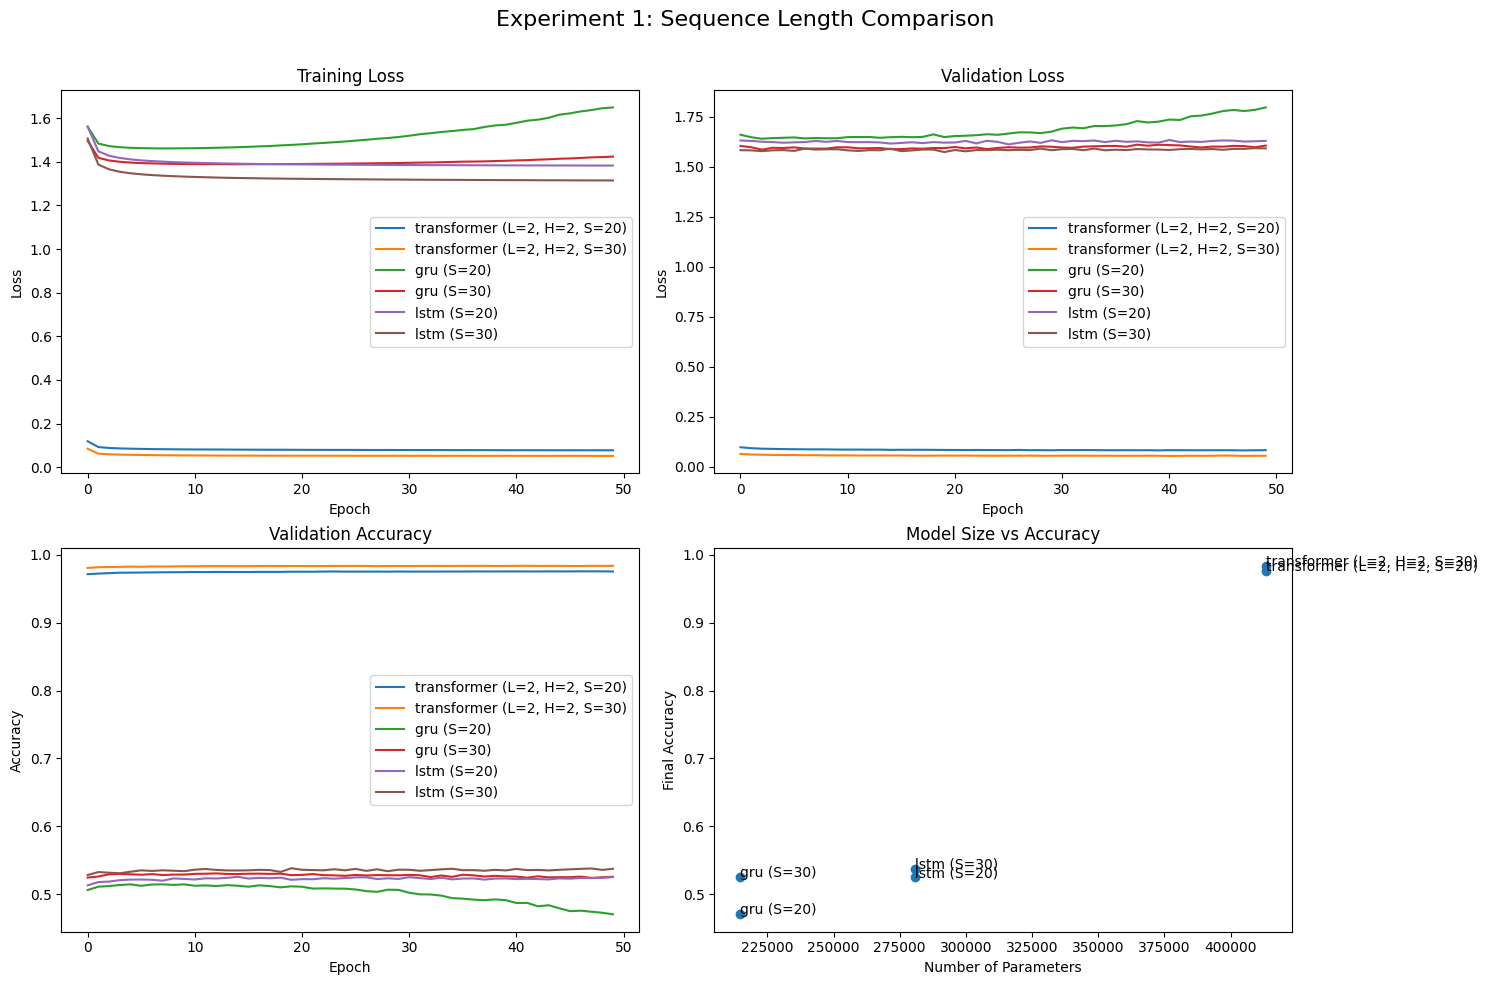

Running Experiment 2: Adjusting hyperparameters for transformer models

=== Training Transformer with 1 layers, 2 heads ===
Model has 214,977 parameters
Epoch 1/3
Batch 100/31370, Loss: 2.2444
Batch 200/31370, Loss: 0.8393
Batch 300/31370, Loss: 0.4200
Batch 400/31370, Loss: 0.2293
Batch 500/31370, Loss: 0.1827
Batch 600/31370, Loss: 0.1454
Batch 700/31370, Loss: 0.1240
Batch 800/31370, Loss: 0.1205
Batch 900/31370, Loss: 0.1604
Batch 1000/31370, Loss: 0.1220
Batch 1100/31370, Loss: 0.1243
Batch 1200/31370, Loss: 0.1022
Batch 1300/31370, Loss: 0.1076
Batch 1400/31370, Loss: 0.1492
Batch 1500/31370, Loss: 0.1392
Batch 1600/31370, Loss: 0.1160
Batch 1700/31370, Loss: 0.1485
Batch 1800/31370, Loss: 0.1253
Batch 1900/31370, Loss: 0.0999
Batch 2000/31370, Loss: 0.1313
Batch 2100/31370, Loss: 0.1129
Batch 2200/31370, Loss: 0.1313
Batch 2300/31370, Loss: 0.1221
Batch 2400/31370, Loss: 0.1085
Batch 2500/31370, Loss: 0.1199
Batch 2600/31370, Loss: 0.0971
Batch 2700/31370, Loss: 0.1045
Batch 280

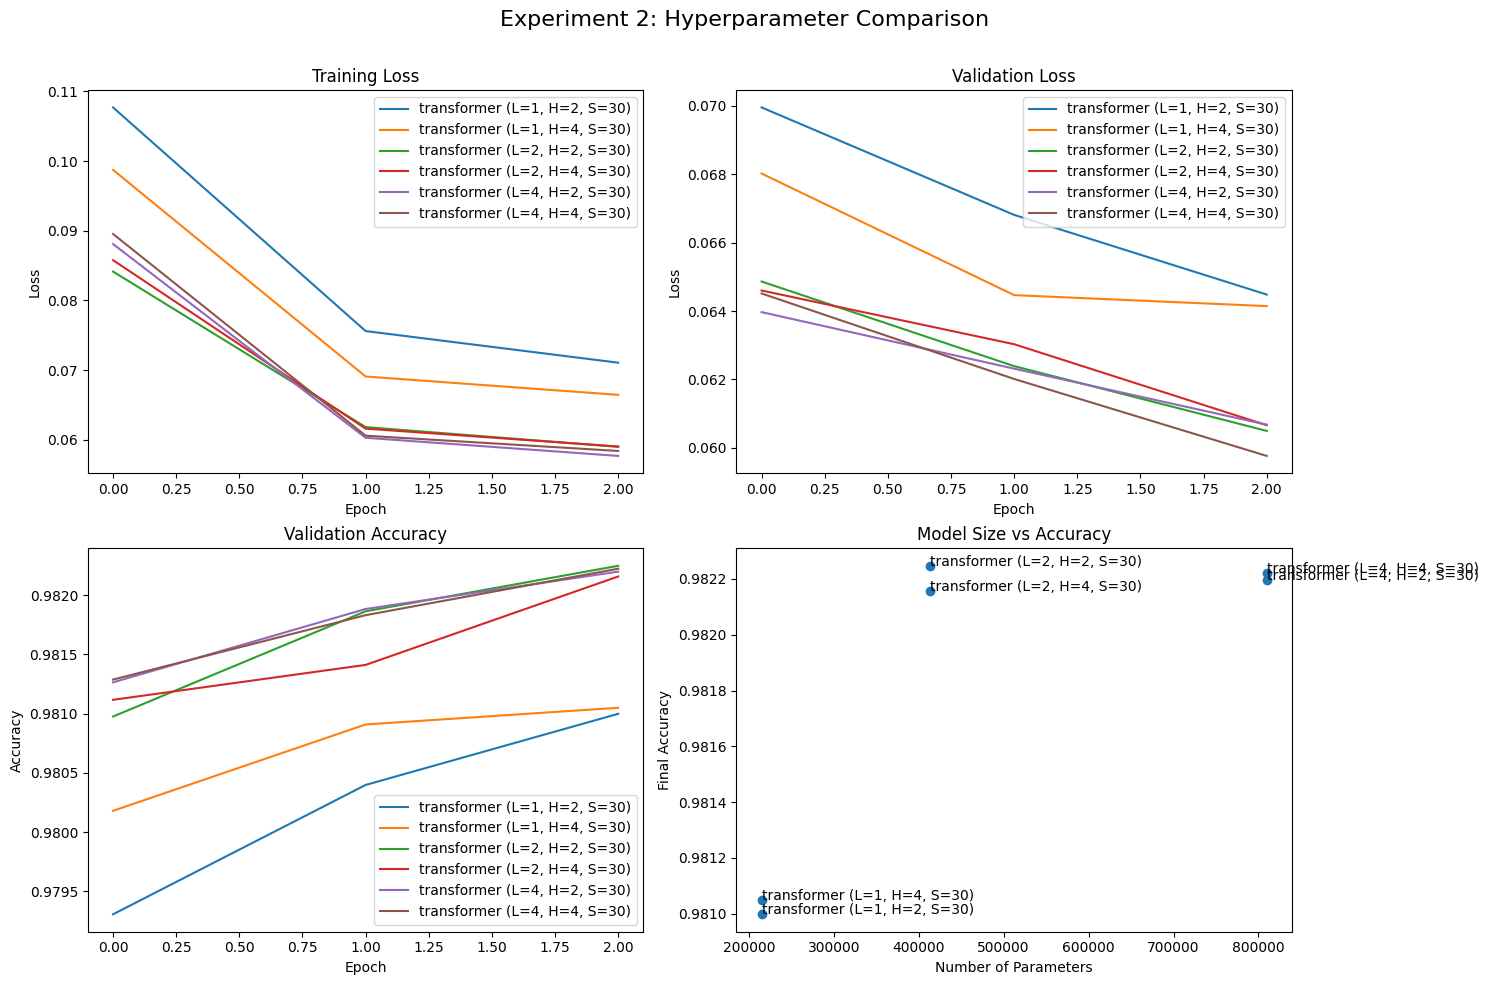

Running Experiment 3: Increasing sequence length to 50

=== Experiment 3: Sequence Length 50 ===
Model has 413,249 parameters
Epoch 1/5
Batch 100/31369, Loss: 2.3723
Batch 200/31369, Loss: 1.0554
Batch 300/31369, Loss: 0.2033
Batch 400/31369, Loss: 0.0936
Batch 500/31369, Loss: 0.0797
Batch 600/31369, Loss: 0.0847
Batch 700/31369, Loss: 0.0721
Batch 800/31369, Loss: 0.0627
Batch 900/31369, Loss: 0.0635
Batch 1000/31369, Loss: 0.0729
Batch 1100/31369, Loss: 0.0567
Batch 1200/31369, Loss: 0.0655
Batch 1300/31369, Loss: 0.0537
Batch 1400/31369, Loss: 0.0606
Batch 1500/31369, Loss: 0.0514
Batch 1600/31369, Loss: 0.0698
Batch 1700/31369, Loss: 0.0526
Batch 1800/31369, Loss: 0.0535
Batch 1900/31369, Loss: 0.0606
Batch 2000/31369, Loss: 0.0622
Batch 2100/31369, Loss: 0.0614
Batch 2200/31369, Loss: 0.0673
Batch 2300/31369, Loss: 0.0522
Batch 2400/31369, Loss: 0.0539
Batch 2500/31369, Loss: 0.0554
Batch 2600/31369, Loss: 0.0487
Batch 2700/31369, Loss: 0.0530
Batch 2800/31369, Loss: 0.0499
Batch

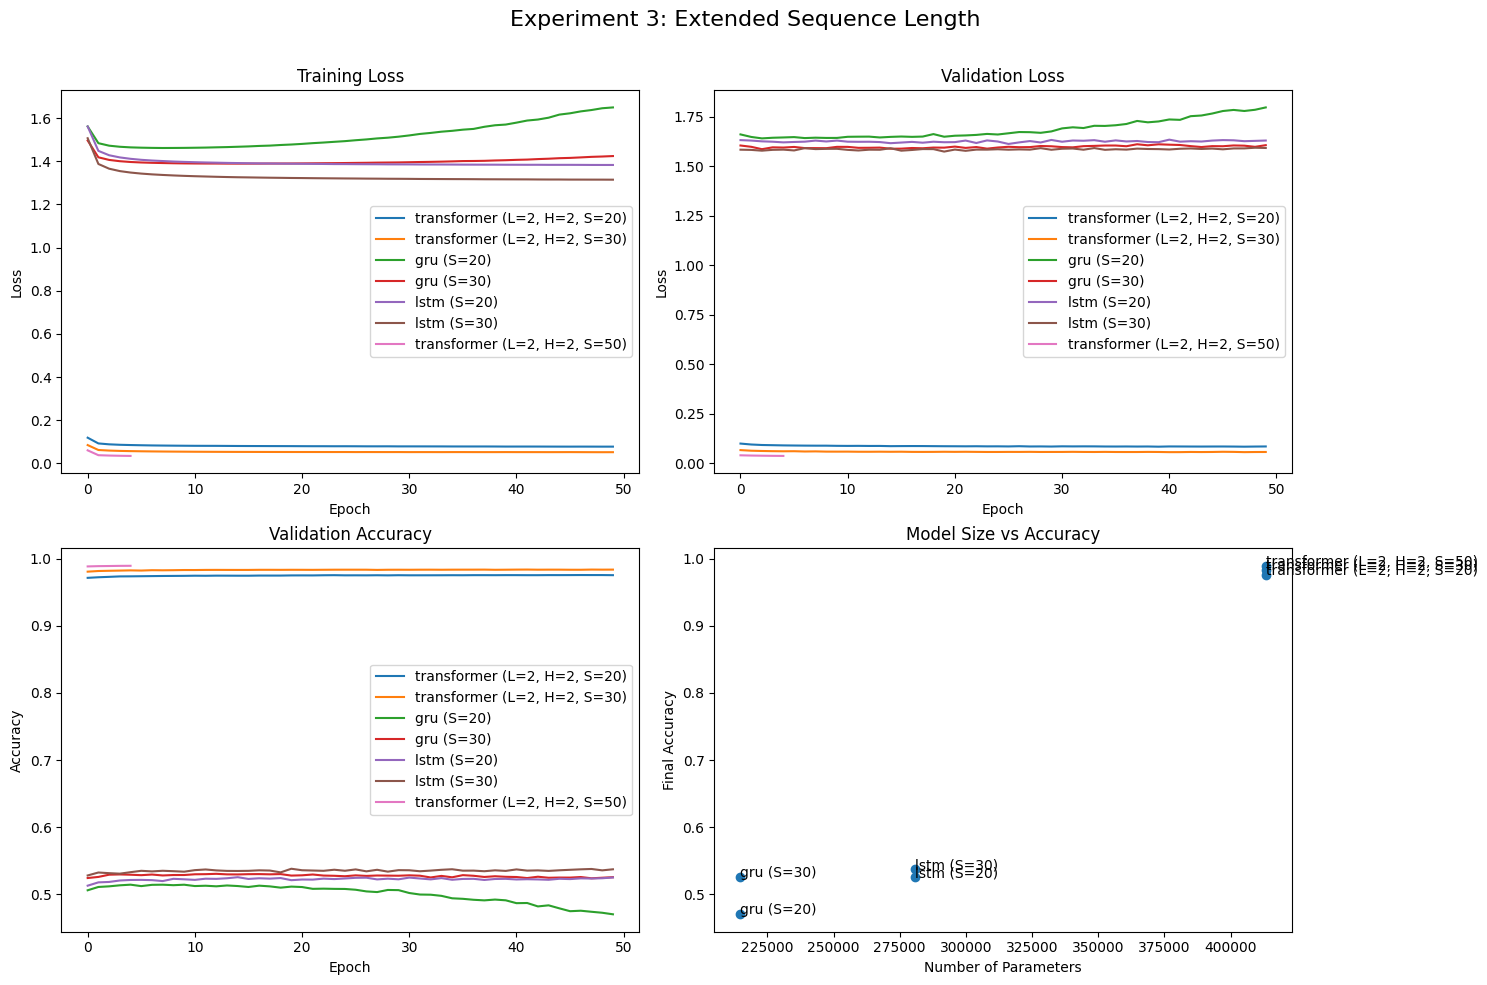

All experiments completed!


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset, DataLoader
import math

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data loading and preprocessing
class CharDataset(Dataset):
    def __init__(self, data, seq_length, vocab_size):
        super().__init__()
        self.data = data
        self.seq_length = seq_length
        self.vocab_size = vocab_size
        
    def __len__(self):
        return len(self.data) - self.seq_length - 1
    
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_length]
        y = self.data[idx+1:idx+self.seq_length+1]
        return x, y

def load_shakespeare_data(sequence_length):
    # Load tiny Shakespeare dataset
    with open('tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
        text = f.read()
    
    # Create character level vocabulary
    chars = sorted(list(set(text)))
    vocab_size = len(chars)
    
    # Create mappings
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}
    
    # Convert text to indices
    data = torch.tensor([char_to_idx[ch] for ch in text], dtype=torch.long)
    
    # Split data
    n = len(data)
    train_data = data[:int(n * 0.9)]
    val_data = data[int(n *.9):]
    
    # Create datasets
    train_dataset = CharDataset(train_data, sequence_length, vocab_size)
    val_dataset = CharDataset(val_data, sequence_length, vocab_size)
    
    return train_dataset, val_dataset, vocab_size, char_to_idx, idx_to_char

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=5000):
        super().__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        # Register buffer (not a parameter but should be saved)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # Add positional encoding to input
        return x + self.pe[:, :x.size(1)].to(x.device)

# Self-Attention Module
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Linear projections for Query, Key, Value, and output
        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)
        self.wo = nn.Linear(d_model, d_model)
        
    def split_heads(self, x):
        batch_size, seq_len, _ = x.size()
        return x.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
    
    def combine_heads(self, x):
        batch_size, _, seq_len, _ = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
    
    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        
        # Linear projections and split into heads
        q = self.split_heads(self.wq(q))  # (batch_size, num_heads, seq_len, d_k)
        k = self.split_heads(self.wk(k))  # (batch_size, num_heads, seq_len, d_k)
        v = self.split_heads(self.wv(v))  # (batch_size, num_heads, seq_len, d_k)
        
        # Scaled dot-product attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask to prevent attending to future tokens
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attn_weights = F.softmax(scores, dim=-1)
        attn_output = torch.matmul(attn_weights, v)  # (batch_size, num_heads, seq_len, d_k)
        
        # Combine heads and apply final linear layer
        output = self.wo(self.combine_heads(attn_output))  # (batch_size, seq_len, d_model)
        
        return output

# Feed-Forward Network
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        
    def forward(self, x):
        # Apply two linear transformations with ReLU in between
        return self.linear2(F.relu(self.linear1(x)))

# Transformer Layer
class TransformerLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # Self-attention with residual connection and layer normalization
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # Feed-forward with residual connection and layer normalization
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout=0.1):
        super().__init__()
        
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        
        self.transformer_layers = nn.ModuleList([
            TransformerLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(d_model, vocab_size)
        
        # Initialize parameters with Glorot / fan_avg
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
                
        self.d_model = d_model
        self.num_heads = num_heads
        self.num_layers = num_layers
        
    def forward(self, x, mask=None):
        # Get sequence length
        seq_length = x.size(1)
        
        # Token embedding and positional encoding
        x = self.token_embedding(x) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)
        x = self.dropout(x)
        
        # Apply transformer layers
        for layer in self.transformer_layers:
            x = layer(x, mask)
            
        # Output layer
        logits = self.output_layer(x)
        
        return logits
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# GRU (RNN) Model for comparison
class GRUModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, dropout=0.1):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        
        # GRU
        output, _ = self.gru(x)
        
        # Output layer
        logits = self.output_layer(output)
        
        return logits
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# LSTM (RNN) Model for comparison
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, dropout=0.1):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        
        # LSTM
        output, _ = self.lstm(x)
        
        # Output layer
        logits = self.output_layer(output)
        
        return logits
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# Training and evaluation functions
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    start_time = time.time()
    
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Reshape for cross-entropy loss
        outputs = outputs.view(-1, outputs.size(-1))
        targets = targets.view(-1)
        
        # Calculate loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)  # Gradient clipping
        optimizer.step()
        
        total_loss += loss.item()
        
        if (batch_idx + 1) % 100 == 0:
            print(f'Batch {batch_idx+1}/{len(dataloader)}, Loss: {loss.item():.4f}')
            
    epoch_time = time.time() - start_time
    return total_loss / len(dataloader), epoch_time

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    start_time = time.time()
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            outputs_flat = outputs.view(-1, outputs.size(-1))
            targets_flat = targets.view(-1)
            loss = criterion(outputs_flat, targets_flat)
            
            # Calculate accuracy
            preds = outputs.argmax(dim=-1)
            correct += (preds == targets).sum().item()
            total += targets.numel()
            
            total_loss += loss.item()
            
    accuracy = correct / total
    eval_time = time.time() - start_time
    return total_loss / len(dataloader), accuracy, eval_time

def generate_text(model, seed_text, char_to_idx, idx_to_char, seq_length, num_chars=100, temperature=1.0):
    model.eval()
    
    # Convert seed text to tensor
    seed_indices = torch.tensor([char_to_idx.get(c, 0) for c in seed_text], dtype=torch.long).unsqueeze(0).to(device)
    
    if len(seed_indices[0]) < seq_length:
        # Pad with zeros if needed
        padding = torch.zeros(1, seq_length - len(seed_indices[0]), dtype=torch.long).to(device)
        seed_indices = torch.cat([padding, seed_indices], dim=1)
    elif len(seed_indices[0]) > seq_length:
        # Take only the last seq_length characters
        seed_indices = seed_indices[:, -seq_length:]
    
    generated_text = [idx_to_char[idx.item()] for idx in seed_indices[0]]
    
    # Generate new characters
    for _ in range(num_chars):
        # Get prediction
        with torch.no_grad():
            output = model(seed_indices)
        
        # Take the last character prediction
        logits = output[0, -1, :]
        
        # Apply temperature for sampling
        probs = F.softmax(logits / temperature, dim=0)
        
        # Sample from the distribution
        next_char_idx = torch.multinomial(probs, 1).item()
        
        # Add to generated text
        generated_text.append(idx_to_char[next_char_idx])
        
        # Update seed indices
        seed_indices = torch.cat([seed_indices[:, 1:], torch.tensor([[next_char_idx]]).to(device)], dim=1)
    
    return ''.join(generated_text[-num_chars:])  # Return only the newly generated part

# Main training function
def train_model(model_type, model_params, seq_length, batch_size=32, epochs=50):
    # Load data
    train_dataset, val_dataset, vocab_size, char_to_idx, idx_to_char = load_shakespeare_data(seq_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    if model_type == 'transformer':
        model = TransformerModel(
            vocab_size=vocab_size,
            d_model=model_params['d_model'],
            num_heads=model_params['num_heads'],
            num_layers=model_params['num_layers'],
            d_ff=model_params['d_ff'],
            max_seq_length=seq_length,
            dropout=model_params['dropout']
        ).to(device)
    elif model_type == 'gru':
        model = GRUModel(
            vocab_size=vocab_size,
            hidden_size=model_params['hidden_size'],
            num_layers=model_params['num_layers'],
            dropout=model_params['dropout']
        ).to(device)
    elif model_type == 'lstm':
        model = LSTMModel(
            vocab_size=vocab_size,
            hidden_size=model_params['hidden_size'],
            num_layers=model_params['num_layers'],
            dropout=model_params['dropout']
        ).to(device)
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Calculate model parameters
    num_params = model.count_parameters()
    print(f"Model has {num_params:,} parameters")
    
    # Initialize optimizer and criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # Training loop
    train_losses = []
    val_losses = []
    val_accuracies = []
    train_times = []
    eval_times = []
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        # Train
        train_loss, epoch_time = train_epoch(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)
        train_times.append(epoch_time)
        
        # Evaluate
        val_loss, val_acc, eval_time = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        eval_times.append(eval_time)
        
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Epoch time: {epoch_time:.2f}s, Eval time: {eval_time:.2f}s")
        
        # Generate sample text
        sample_text = generate_text(model, "KING RICHARD III:", char_to_idx, idx_to_char, seq_length, num_chars=100)
        print(f"Sample text: {sample_text}")
        
    # Calculate perplexity
    final_perplexity = math.exp(val_losses[-1])
    
    # Return results
    results = {
        'model_type': model_type,
        'model_params': model_params,
        'seq_length': seq_length,
        'num_params': num_params,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'final_accuracy': val_accuracies[-1],
        'perplexity': final_perplexity,
        'avg_train_time': sum(train_times) / len(train_times),
        'avg_eval_time': sum(eval_times) / len(eval_times),
        'sample_text': sample_text
    }
    
    return model, results

# Experiment 1: Comparing sequence lengths 20 and 30 for transformer vs RNN models
def run_experiment_1():
    results = []
    
    # Transformer with seq_length=20
    transformer_params_20 = {
        'd_model': 128,
        'num_heads': 2,
        'num_layers': 2,
        'd_ff': 512,
        'dropout': 0.1
    }
    _, trans_results_20 = train_model('transformer', transformer_params_20, seq_length=20, epochs=50)
    results.append(trans_results_20)
    
    # Transformer with seq_length=30
    transformer_params_30 = {
        'd_model': 128,
        'num_heads': 2,
        'num_layers': 2,
        'd_ff': 512,
        'dropout': 0.1
    }
    _, trans_results_30 = train_model('transformer', transformer_params_30, seq_length=30, epochs=50)
    results.append(trans_results_30)
    
    # GRU with seq_length=20
    gru_params_20 = {
        'hidden_size': 128,
        'num_layers': 2,
        'dropout': 0.1
    }
    _, gru_results_20 = train_model('gru', gru_params_20, seq_length=20, epochs=50)
    results.append(gru_results_20)
    
    # GRU with seq_length=30
    gru_params_30 = {
        'hidden_size': 128,
        'num_layers': 2,
        'dropout': 0.1
    }
    _, gru_results_30 = train_model('gru', gru_params_30, seq_length=30, epochs=50)
    results.append(gru_results_30)
    
    # LSTM with seq_length=20
    lstm_params_20 = {
        'hidden_size': 128,
        'num_layers': 2,
        'dropout': 0.1
    }
    _, lstm_results_20 = train_model('lstm', lstm_params_20, seq_length=20, epochs=50)
    results.append(lstm_results_20)
    
    # LSTM with seq_length=30
    lstm_params_30 = {
        'hidden_size': 128,
        'num_layers': 2,
        'dropout': 0.1
    }
    _, lstm_results_30 = train_model('lstm', lstm_params_30, seq_length=30, epochs=50)
    results.append(lstm_results_30)
    
    # Print comparison
    print("\n=== Experiment 1: Sequence Length Comparison ===")
    for result in results:
        print(f"Model: {result['model_type']}, Seq Length: {result['seq_length']}")
        print(f"Parameters: {result['num_params']:,}")
        print(f"Final Accuracy: {result['final_accuracy']:.4f}")
        print(f"Perplexity: {result['perplexity']:.4f}")
        print(f"Avg Train Time: {result['avg_train_time']:.2f}s")
        print(f"Avg Eval Time: {result['avg_eval_time']:.2f}s")
        print()
    
    return results

# Experiment 2: Adjusting hyperparameters for transformer models
def run_experiment_2():
    results = []
    sequence_length = 30
    
    # Try different combinations of layers and heads
    for num_layers in [1, 2, 4]:
        for num_heads in [2, 4]:
            transformer_params = {
                'd_model': 128,  # Keep d_model fixed
                'num_heads': num_heads,
                'num_layers': num_layers,
                'd_ff': 512,
                'dropout': 0.1
            }
            
            print(f"\n=== Training Transformer with {num_layers} layers, {num_heads} heads ===")
            _, trans_results = train_model('transformer', transformer_params, seq_length=sequence_length, epochs=3)
            results.append(trans_results)
    
    # Print comparison
    print("\n=== Experiment 2: Hyperparameter Comparison ===")
    for result in results:
        model_params = result['model_params']
        print(f"Layers: {model_params['num_layers']}, Heads: {model_params['num_heads']}")
        print(f"Parameters: {result['num_params']:,}")
        print(f"Final Accuracy: {result['final_accuracy']:.4f}")
        print(f"Perplexity: {result['perplexity']:.4f}")
        print(f"Avg Train Time: {result['avg_train_time']:.2f}s")
        print(f"Avg Eval Time: {result['avg_eval_time']:.2f}s")
        print()
    
    return results

# Experiment 3: Increasing sequence length to 50
def run_experiment_3():
    # Train model with sequence length 50
    transformer_params = {
        'd_model': 128,
        'num_heads': 2,
        'num_layers': 2,
        'd_ff': 512,
        'dropout': 0.1
    }
    
    print("\n=== Experiment 3: Sequence Length 50 ===")
    _, result = train_model('transformer', transformer_params, seq_length=50, epochs=5)
    
    print(f"Model: {result['model_type']}, Seq Length: {result['seq_length']}")
    print(f"Parameters: {result['num_params']:,}")
    print(f"Final Accuracy: {result['final_accuracy']:.4f}")
    print(f"Perplexity: {result['perplexity']:.4f}")
    print(f"Avg Train Time: {result['avg_train_time']:.2f}s")
    print(f"Avg Eval Time: {result['avg_eval_time']:.2f}s")
    
    return result

# Plot results of experiments
def plot_results(experiment_results, title):
    plt.figure(figsize=(15, 10))
    
    # Plot training losses
    plt.subplot(2, 2, 1)
    for result in experiment_results:
        model_type = result['model_type']
        seq_length = result['seq_length']
        if 'num_heads' in result['model_params']:
            num_layers = result['model_params']['num_layers']
            num_heads = result['model_params']['num_heads']
            label = f"{model_type} (L={num_layers}, H={num_heads}, S={seq_length})"
        else:
            label = f"{model_type} (S={seq_length})"
        plt.plot(result['train_losses'], label=label)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot validation losses
    plt.subplot(2, 2, 2)
    for result in experiment_results:
        model_type = result['model_type']
        seq_length = result['seq_length']
        if 'num_heads' in result['model_params']:
            num_layers = result['model_params']['num_layers']
            num_heads = result['model_params']['num_heads']
            label = f"{model_type} (L={num_layers}, H={num_heads}, S={seq_length})"
        else:
            label = f"{model_type} (S={seq_length})"
        plt.plot(result['val_losses'], label=label)
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot validation accuracies
    plt.subplot(2, 2, 3)
    for result in experiment_results:
        model_type = result['model_type']
        seq_length = result['seq_length']
        if 'num_heads' in result['model_params']:
            num_layers = result['model_params']['num_layers']
            num_heads = result['model_params']['num_heads']
            label = f"{model_type} (L={num_layers}, H={num_heads}, S={seq_length})"
        else:
            label = f"{model_type} (S={seq_length})"
        plt.plot(result['val_accuracies'], label=label)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot model size vs accuracy
    plt.subplot(2, 2, 4)
    model_sizes = [result['num_params'] for result in experiment_results]
    accuracies = [result['final_accuracy'] for result in experiment_results]
    labels = []
    for result in experiment_results:
        model_type = result['model_type']
        seq_length = result['seq_length']
        if 'num_heads' in result['model_params']:
            num_layers = result['model_params']['num_layers']
            num_heads = result['model_params']['num_heads']
            label = f"{model_type} (L={num_layers}, H={num_heads}, S={seq_length})"
        else:
            label = f"{model_type} (S={seq_length})"
        labels.append(label)
    
    plt.scatter(model_sizes, accuracies)
    for i, label in enumerate(labels):
        plt.annotate(label, (model_sizes[i], accuracies[i]))
    plt.title('Model Size vs Accuracy')
    plt.xlabel('Number of Parameters')
    plt.ylabel('Final Accuracy')
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.show()

# Main execution
if __name__ == "__main__":
    print("Running Experiment 1: Comparing sequence lengths 20 and 30 for transformer vs RNN models")
    exp1_results = run_experiment_1()
    plot_results(exp1_results, "Experiment 1: Sequence Length Comparison")
    
    print("Running Experiment 2: Adjusting hyperparameters for transformer models")
    exp2_results = run_experiment_2()
    plot_results(exp2_results, "Experiment 2: Hyperparameter Comparison")
    
    print("Running Experiment 3: Increasing sequence length to 50")
    exp3_result = run_experiment_3()
    # Add to previous results to compare
    plot_results(exp1_results + [exp3_result], "Experiment 3: Extended Sequence Length")
    
    print("All experiments completed!")